In [97]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten ,InputLayer, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [98]:
dataset, dataset_info = tfds.load("cats_vs_dogs", with_info=True,as_supervised =True, shuffle_files=True , split = "train")

In [99]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [100]:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

# PreProcessing

In [101]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

train_dataset = dataset.take(int(TRAIN_RATIO*len(dataset)))
val_dataset = dataset.skip(int(TRAIN_RATIO*len(dataset))).take(int(VAL_RATIO*len(dataset)))
test_dataset = dataset.skip(int((TRAIN_RATIO+VAL_RATIO)*len(dataset)))
print(train_dataset)

def print_dataset_shape(dataset):
    for element in dataset.take(1):  # Take one batch
        print(f"Shape of element: {element[0].shape}")  # Assuming the first element is the input; adjust if necessary
        break
# print("Training Dataset Shape:")
# print_dataset_shape(train_dataset)

# print("Validation Dataset Shape:")
# print_dataset_shape(val_dataset)

# print("Test Dataset Shape:")
# print_dataset_shape(test_dataset)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


# Data Visualization

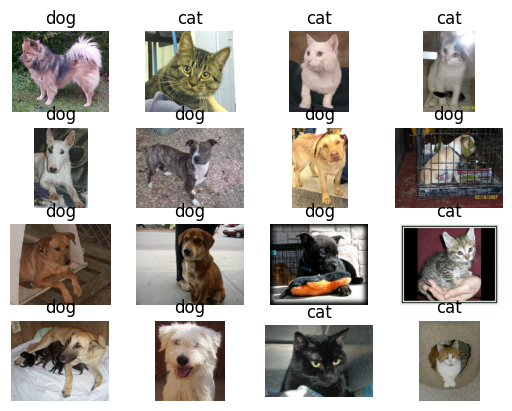

In [102]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

# Data Processing

In [103]:
IM_SIZE = 224
def resizing_rescale(image, label):
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label
    return image, label

In [104]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [105]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [106]:
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# CNN Model (LeNET)

In [107]:
model =tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    tf.keras.layers.Conv2D(filters = 6,kernel_size = 3,strides=(1, 1),padding='valid', activation ="relu"),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size=(2, 2),strides=2),
    tf.keras.layers.Conv2D(filters = 6,kernel_size = 3,strides=(1, 1),padding='valid', activation ="relu"),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 6)         │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 17496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │       1,749,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,751,707 (6.68 MB)

 Trainable params: 1,751,463 (6.68 MB)

 Non-trainable params: 244 (976.00 B)

# Trainning CNN

In [108]:
model.compile(optimizer=Adam(learning_rate = 0.01), loss=BinaryCrossentropy )

In [ ]:
history  = model.fit(train_dataset, validation_data=val_dataset, epochs =100, verbose = 1)

Epoch 1/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - loss: 0.7236 - val_loss: 0.7798
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 75s 102ms/step - loss: 0.6551 - val_loss: 0.9631
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 83s 105ms/step - loss: 0.5983 - val_loss: 0.6507
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.5145 - val_loss: 0.6807
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - loss: 0.4486 - val_loss: 0.6978
Epoch 6/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.3526 - val_loss: 0.8762
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 81s 100ms/step - loss: 0.2443 - val_loss: 1.1960
Epoch 8/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 84s 104ms/step - loss: 0.2268 - val_loss: 1.0433
Epoch 9/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.1828 - val_loss: 1.0274
Epoch 10/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - loss: 0.1391 - val_loss: 1.0874
Epoch 11/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 79s 102ms/step - loss: 0.1273 - val_loss: 1.1536
Epoch 12